<a href="https://colab.research.google.com/github/gi3265/-DACON-Bit_Trader/blob/main/%5BDacon%5DBit_Trader_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Library Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# 2. 데이터 가공

## 2.1 read_csv

In [ ]:
data_path = '/content/drive/MyDrive/Dacon_Data/[DACON]Bit_Trader/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## 2.2 numpy array로 변환

In [ ]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)   #(7362, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(7362, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

# 3. 모델 훈련하기

## 3.2 validation set 훈련(sample_id: 0~529)

### 3.2.1 validation 데이터 생성하기

In [ ]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df#[train_x_df.sample_id < 529]
valid_y_df = train_y_df#[train_y_df.sample_id < 529]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([len(valid_x_array), 120, 1])

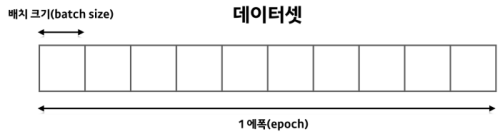

100개의 데이터가 있을 때 배치 크기가 1이면 모델은 1 에폭당 100번 훈련합니다. 배치 크기가 10이면 10번의 훈련, 배치 크기가 100이면 1번 훈련합니다.

#### Window 만들기

In [ ]:
#(7362, 1380, 10)
#(7362, 120, 10)
#(529, 1380, 10)

In [ ]:
test_pred_array = np.zeros([529, 120, 1])

for idx in tqdm(range(valid_x_array.shape[0])):
    #window 만들기
    seq_len = 120 #window_size와 같은 개념
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380- sequence_length):
      windows.append(valid_x_array[idx,:,1][index: index+ sequence_length])  #출력값은 open자료값으로 구성된 window들
    
    #train, test데이터 구성
    x_train = windows[:,:-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = windows[:, -1]

  0%|          | 0/7362 [00:00<?, ?it/s]


TypeError: ignored

## 3.1 훈련 층 쌓기(모델 구성)

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape = [seq_len, 1])) #input_shape=(n_steps, n_features)
model.add(Dense(240))
model.add(Dense(1))
model.add(Reshape([window_size,1]))

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(patience = 5)

In [ ]:
model.summary()

---

### 3.2.2 학습 및 test_x 예측하고 해당 내용 test_pred_array에 기록

In [ ]:
history = model.fit(x_train, y_train, epochs = 3, batch_size = window_size, verbose = 2) #epochs = 30, batch_size = 138이 깊은 학습을 하기에는 적당했음. #callbacks = [earlystopping]

In [ ]:
#여기서 predict를 바로 해야 함?
preds = model.predict()
test_pred_array[idx,:] = preds

In [ ]:
test_pred_array.shape

# 3. 모델 저장 및 로드

In [ ]:
model.save('./drive/MyDrive/Dacon_Data/[DACON]Bit_Trader/my_model.h5')

In [ ]:
model = tf.keras.models.load_model('./drive/MyDrive/Dacon_Data/[DACON]Bit_Trader/my_model.h5')

# 4. 예측 기록을 바탕으로 투자 지침 표(submission)만들기

In [ ]:
#train_pred_array 3차원에서 2차원으로 바꾸기

new_pred_array = np.zeros([len(test_x_array), 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    val_open = test_pred_array[idx, :, 0]
    new_pred_array[idx, :] = val_open
    new_pred_array

In [ ]:
new_pred_array.shape

## 4.1 매수 시점, 매수 비율 표 작성

In [ ]:
def array_to_submission(pred_array):

    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
valid_submission = array_to_submission(new_pred_array)
valid_submission

In [ ]:
valid_submission.to_csv('./drive/MyDrive/Dacon_Data/[DACON]Bit_Trader/submission.csv', index = False)

In [ ]:
# 전체 300가지 sample에 대해
# _가지 case에서 x% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

---

# 모델 평가: 샘플에서 실제값과 예측값 비교

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [ ]:
idx = 500
# train data 중 sample_id idx에 해당하는 x_series로 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), test_pred_array[idx], label = 'prediction')
plt.legend()
plt.show()

In [ ]:
#test_y 예측하기 위한 자료인 test_x값 시각화
plt.plot(test_x_array[idx,:,1])
plt.plot(np.arange(1380, 1380+120), test_pred_array[idx], label = 'prediction')
plt.legend()
plt.show()

train_x와 test_x의 값이 엄연히 다름에도 idx값이 늘어나며 학습이 진행됨에 따라 test_y 예측값이 train_y의 값과 너무 똑같이 정해진다. 학습이 과적합되는 듯? \
-> Sol1) lstm 모델에 dropoutlayer 추가해서 다시 학습해보자\
   Sol2) Windows 개념 적용

# 투자 후 금액 계산하기

In [ ]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [ ]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [ ]:
# 투자 후 금액
print(total_momey)

In [ ]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

---